# Title: What is the Myers–Briggs Type Indicator (MBTI) Associated with the musical features of a playlist?

## Tasks: (due date: April 7th, 11:59 pm)
* add explanations to visualization and a conclusion to the EDA - Roy
* read dataset from web - email the TA - CC
* performs the data analysis - Megan
* creates a visualization of the analysis - Josh

Link to the dataset: https://www.kaggle.com/datasets/xtrnglc/spotify-mbti-playlists

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(rsample)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Introduction:
The Myers-Briggs Type Indicator (MBTI), based on the theory of psychological types described by C. G. Jung, describes personality across four axes with a total of sixteen distinct combinations (The Myers & Briggs Foundation). Research shows that musical taste is related to personality, but little evidence demonstrates how predictable musical features are. 

This study attempts to classify the MBTI associated with the given musical characteristics of a playlist using a k-nearest neighbor classification model. The dataset, titled "Spotify MBTI Playlists", contains aggregated information on eleven different musical features for a Spotify playlist on each row.

In [2]:
# Read the dataset
spotify_mbti <- read_csv("https://raw.githubusercontent.com/ccliang4/dsci-100-2022w1-sec-005-group-28/main/combined_mbti_df.csv") |>
    mutate(mbti = as_factor(mbti))
spotify_mbti

Rows: 4081 Columns: 46
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): mbti, function_pair
dbl (44): danceability_mean, danceability_stdev, energy_mean, energy_stdev, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mbti,function_pair,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,⋯,Aminor_count,AMajor_count,A#/Bbminor_count,BMajor_count,Dminor_count,D#_Ebminor_count,Gminor_count,A#/BbMajor_count,F#/GbMajor_count,Bminor_count
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,NF,0.5578409,0.1550106,0.5533250,0.2251780,-8.352591,3.273317,0.6590909,0.4794950,⋯,2,2,1,4,0,0,0,0,0,0
INFP,NF,0.5876364,0.1356443,0.5562727,0.1916420,-8.215697,3.356867,0.6363636,0.4885042,⋯,1,2,1,4,1,1,1,1,0,0
INFP,NF,0.6770000,0.1280094,0.8512800,0.1283365,-5.046100,2.180554,0.5800000,0.4985694,⋯,0,1,1,3,1,0,0,1,2,9
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ESTJ,SJ,0.5853125,0.1819083,0.6943750,0.1736364,-5.307063,1.531874,0.5625000,0.5123475,⋯,1,1,2,0,1,0,0,0,0,1
ESTJ,SJ,0.6360400,0.1523822,0.6524200,0.1760419,-6.553020,2.813042,0.5400000,0.5034574,⋯,2,0,3,1,0,1,2,2,1,3
ESTJ,SJ,0.6407333,0.1452048,0.6783333,0.1824823,-5.763733,2.075266,0.5555556,0.5025189,⋯,2,0,4,1,2,0,3,1,2,2


In [3]:
# Clean the dataset by combining all majors and minors into two columns and removing NA rows
spotify_mbti_cleaned <- spotify_mbti |>
    select(-function_pair) |>
    mutate(major_count = CMajor_count + `C#/DbMajor_count` + DMajor_count +
           `D#_EbMajor_count` + EMajor_count + FMajor_count + GMajor_count +
           `G#/AbMajor_count` + AMajor_count + BMajor_count + `A#/BbMajor_count` +
           `F#/GbMajor_count`,
           minor_count = Cminor_count + `C#/Dbminor_count` + Eminor_count +
          Fminor_count + `F#/Gbminor_count` + `G#/Abminor_count` + 
          Aminor_count + `A#/Bbminor_count` + Dminor_count + `D#_Ebminor_count` +
          Gminor_count + Bminor_count) |>
    select(mbti:instrumentalness_stdev, major_count, minor_count) |>
    filter(!is.na(minor_count))

spotify_mbti_cleaned

mbti,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,speechiness_mean,⋯,liveness_mean,liveness_stdev,valence_mean,valence_stdev,tempo_mean,tempo_stdev,instrumentalness_mean,instrumentalness_stdev,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INFP,0.5578409,0.1550106,0.5533250,0.2251780,-8.352591,3.273317,0.6590909,0.4794950,0.06734091,⋯,0.1634023,0.0862659,0.4488841,0.2217635,120.9548,32.16578,0.01997099,0.08180459,29,15
INFP,0.5876364,0.1356443,0.5562727,0.1916420,-8.215697,3.356867,0.6363636,0.4885042,0.07427273,⋯,0.1545424,0.1124957,0.4476030,0.2160687,131.8712,33.21601,0.06104086,0.17755873,21,12
INFP,0.6770000,0.1280094,0.8512800,0.1283365,-5.046100,2.180554,0.5800000,0.4985694,0.27254600,⋯,0.2645200,0.2080966,0.2650300,0.1705175,128.2060,26.92719,0.25035756,0.33180466,29,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ESTJ,0.5853125,0.1819083,0.6943750,0.1736364,-5.307063,1.531874,0.5625000,0.5123475,0.09024375,⋯,0.1578000,0.1065317,0.5220625,0.2437776,122.6099,33.19806,0.0009960725,0.0029272391,9,7
ESTJ,0.6360400,0.1523822,0.6524200,0.1760419,-6.553020,2.813042,0.5400000,0.5034574,0.09537600,⋯,0.1564140,0.1230124,0.5587180,0.2778599,125.0429,29.28428,0.0389386528,0.1495546238,27,23
ESTJ,0.6407333,0.1452048,0.6783333,0.1824823,-5.763733,2.075266,0.5555556,0.5025189,0.10697778,⋯,0.1925044,0.1268794,0.5557111,0.2316916,123.6504,27.03963,0.0001314116,0.0005088235,25,20


In [4]:
# Seed setting and data splitting
set.seed(1)

spotify_split <- initial_split(spotify_mbti_cleaned, prop = 0.75)  
spotify_mbti_train <- training(spotify_split)   
spotify_mbti_test <- testing(spotify_split)

### Summarize the data in tables

In [5]:
# report number of observations in each class
observation_count <- spotify_mbti_train |>
    group_by(mbti) |>
    summarize(count = n())
observation_count

mbti,count
<fct>,<int>
INFP,231
ENFP,225
INFJ,241
⋮,⋮
ESFJ,84
ISTJ,143
ESTJ,82


In [6]:
# report means of the predictor variables
means_table <- spotify_mbti_train |>
    summarize(across(danceability_mean:minor_count, mean, na.rm = TRUE))

glimpse(means_table)

Rows: 1
Columns: 22
$ danceability_mean      <dbl> 0.5937052
$ danceability_stdev     <dbl> 0.1372644
$ energy_mean            <dbl> 0.6351733
$ energy_stdev           <dbl> 0.1753721
$ loudness_mean          <dbl> -7.130696
$ loudness_stdev         <dbl> 2.869923
$ mode_mean              <dbl> 0.6026921
$ mode_stdev             <dbl> 0.4713741
$ speechiness_mean       <dbl> 0.0782699
$ speechiness_stdev      <dbl> 0.06497499
$ acousticness_mean      <dbl> 0.2505405
$ acousticness_stdev     <dbl> 0.2391013
$ liveness_mean          <dbl> 0.1808428
$ liveness_stdev         <dbl> 0.1309472
$ valence_mean           <dbl> 0.4752963
$ valence_stdev          <dbl> 0.2111479
$ tempo_mean             <dbl> 121.892
$ tempo_stdev            <dbl> 28.71042
$ instrumentalness_mean  <dbl> 0.07774629
$ instrumentalness_stdev <dbl> 0.1475589
$ major_count            <dbl> 24.80667
$ minor_count            <dbl> 16.30422


In [7]:
# report how many rows have missing data
na_rows <- spotify_mbti_train[!complete.cases(spotify_mbti_train), ]
na_rows
nrow(na_rows)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


mbti,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,speechiness_mean,⋯,liveness_mean,liveness_stdev,valence_mean,valence_stdev,tempo_mean,tempo_stdev,instrumentalness_mean,instrumentalness_stdev,major_count,minor_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


[1] 0

### Visualize the data with plots

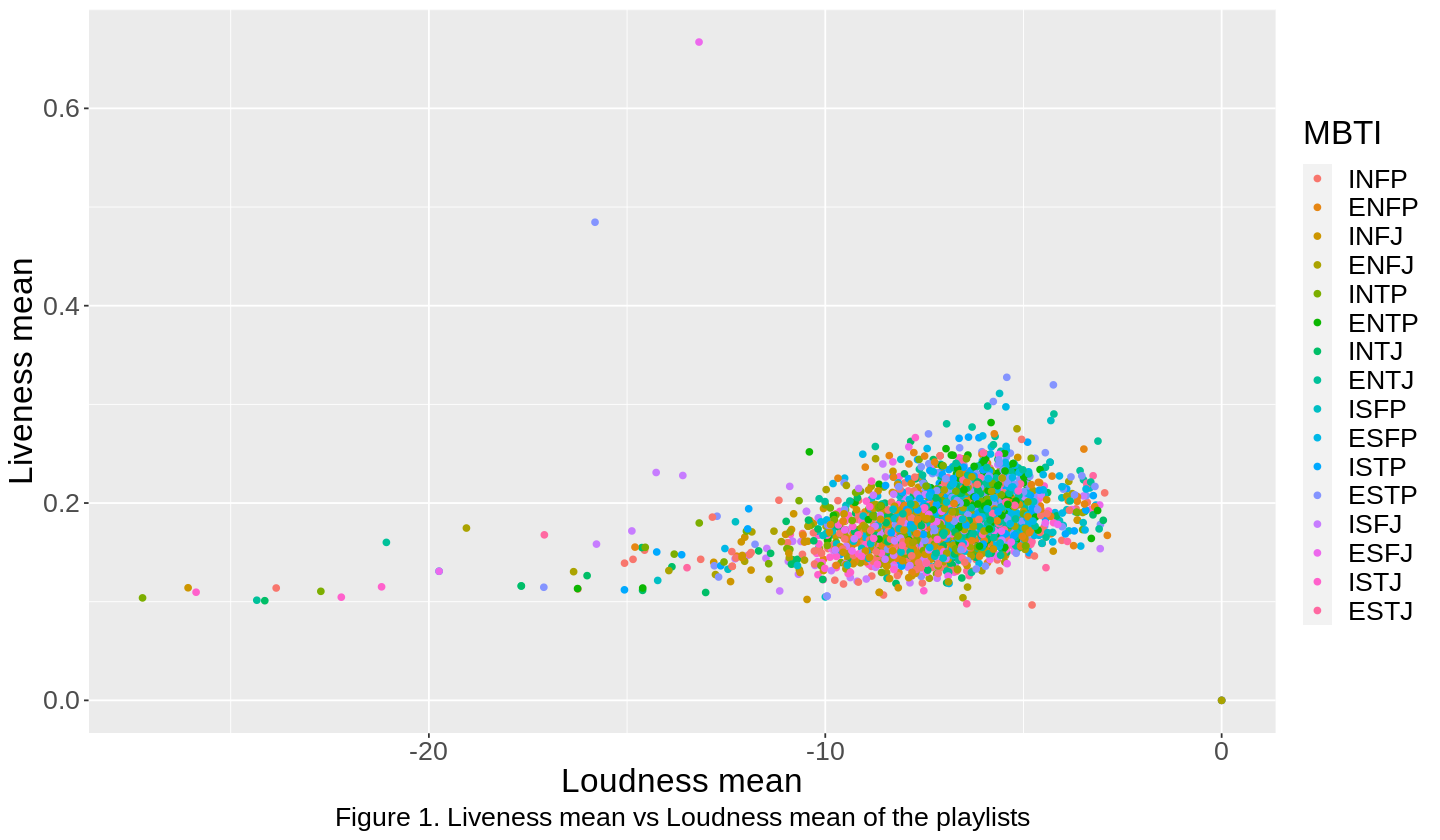

In [8]:
options(repr.plot.width = 12)

# Plot loudness vs liveness
loudness_liveness_mean <- spotify_mbti_train |>  
    ggplot(aes(x = loudness_mean, 
               y = liveness_mean, 
               colour = mbti)) +
    geom_point() +
    labs(x = "Loudness mean",
             y = "Liveness mean",
            colour = 'MBTI',
        caption = 'Figure 1. Liveness mean vs Loudness mean of the playlists') +
    theme(text = element_text(size = 20),
         plot.caption = element_text(hjust=0.5))
loudness_liveness_mean

### As shown in Figure 1, there is no relationship between the liveness mean and loudness mean of the playlists.  The loudness mean varies from about -2 to -30, while the liveness mean mostly ranges from 0.1 to 0.3.

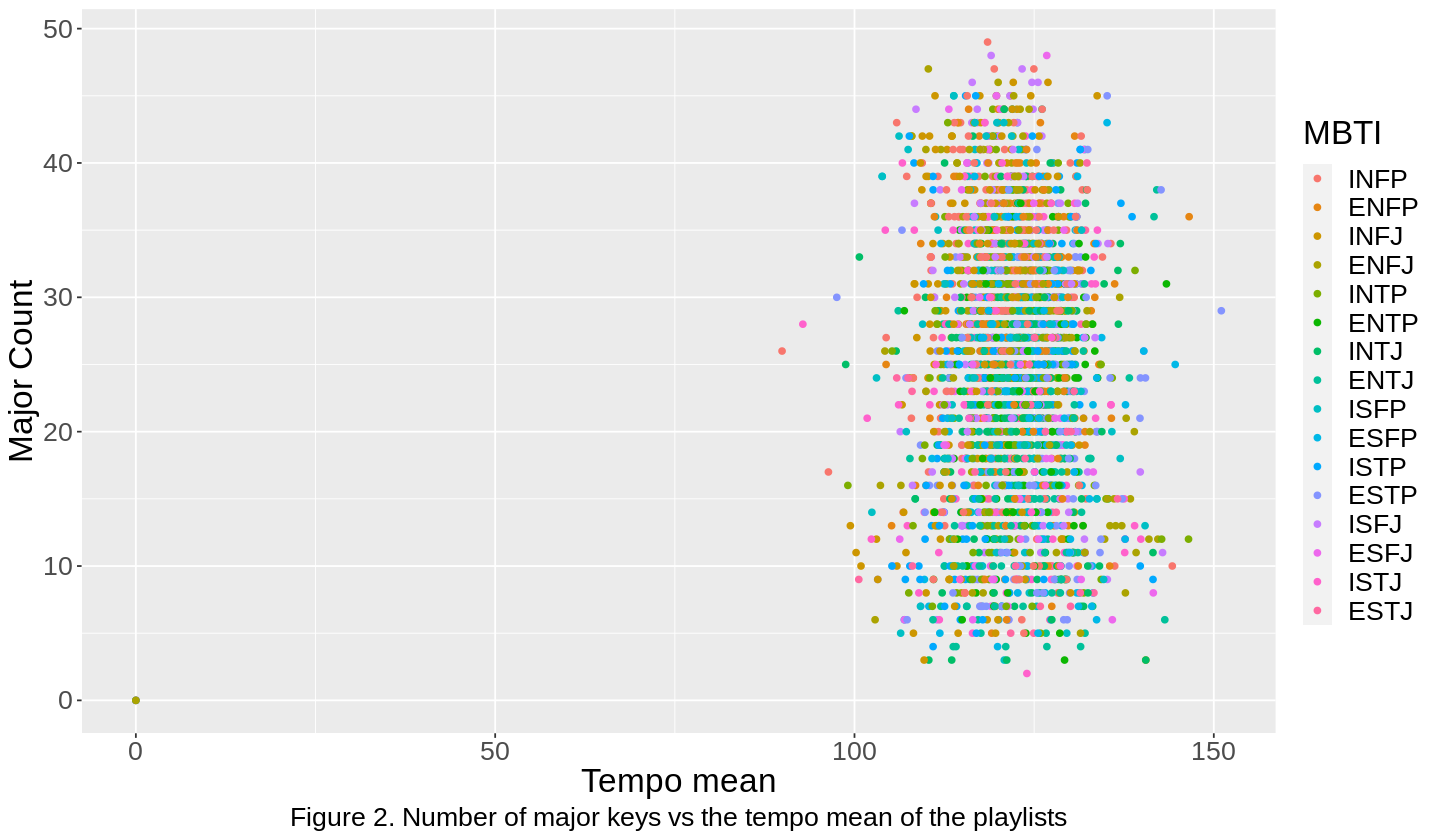

In [9]:
# Plot tempo vs major count
tempo_major_count <- spotify_mbti_train |>  
    ggplot(aes(x = tempo_mean, 
               y = major_count, 
               colour = mbti)) +
    geom_point() +
    labs(x = "Tempo mean",
             y = "Major Count",
            colour = 'MBTI',
          caption = "Figure 2. Number of major keys vs the tempo mean of the playlists") +
    theme(text = element_text(size = 20),
         plot.caption = element_text(hjust=0.5))
tempo_major_count

### As shown in Figure 2, there is no relationship between the count of major keys and tempo means of the playlists. The tempo mean is consistently around 100 to 150, while the count of major keys ranges from 0 to 50.

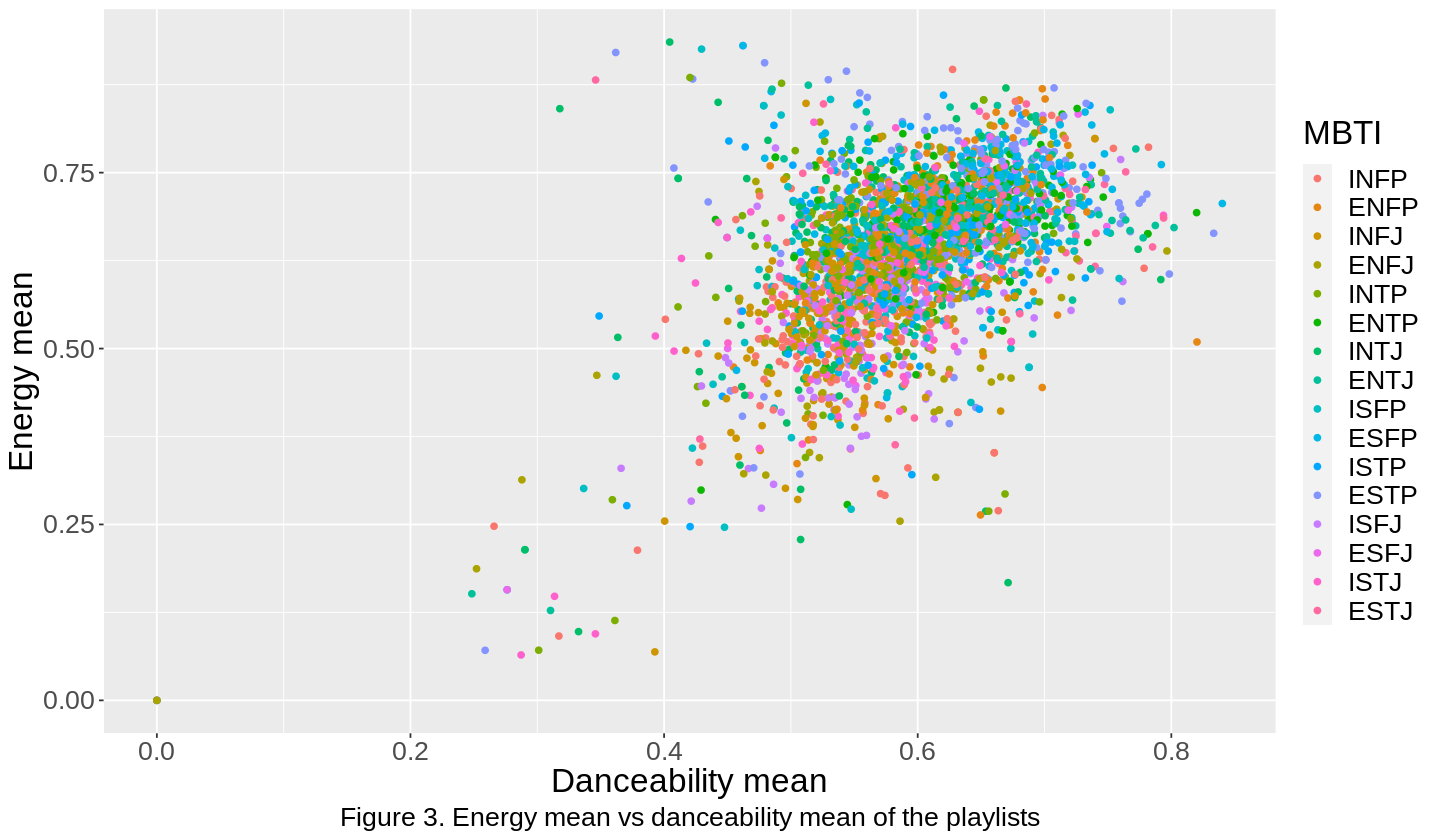

In [10]:
# Plot danceability vs energy
danceability_energy_mean <- spotify_mbti_train |>  
    ggplot(aes(x = danceability_mean, 
               y = energy_mean, 
               colour = mbti)) +
    geom_point() +
    labs(x = "Danceability mean",
             y = "Energy mean",
            colour = 'MBTI',
        caption = 'Figure 3. Energy mean vs danceability mean of the playlists') +
    theme(text = element_text(size = 20),
          plot.caption = element_text(hjust=0.5))
danceability_energy_mean

### As shown in Figure 3, there is a weak positive relationship between the energy mean and danceability mean of the playlists. As the deanceability mean of the playlists increases, the energy mean increases. 

### As shown in the EDA, while some characteristics of playlists have no relationship with each other, some have a relationship, such as the weak positive relationship between the energy mean and danceability mean of the playlists.

## Methods & Results:

INSTRUCTIONS:
describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
* loads data from the original source on the web 
* wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
* performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
* creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
* performs the data analysis
* creates a visualization of the analysis 
* note: all tables and figure should have a figure/table number and a legend


We will conduct our data analysis by using the K-nearest neighbor classification to predict MBTI from the musical features of Spotify playlists. All variables will be used except for function_pair as it represents the same information as mbti. To decrease the number of predictable variables, we will need to put all the majors into one column and all the minors into another. Furthermore, cross-validation will be used to tune the number of neighbors to optimize the model's performance.

One way we will visualize the results is by visualizing the confusion matrix as a bar plot with the number of correctly identified MBTI types plot against the number of incorrectly identified MBTI types.

## Data Analysis

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


.pred_class,mbti,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,⋯,liveness_mean,liveness_stdev,valence_mean,valence_stdev,tempo_mean,tempo_stdev,instrumentalness_mean,instrumentalness_stdev,major_count,minor_count
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ISFJ,INFP,0.5876364,0.1356443,0.5562727,0.1916420,-8.215697,3.356867,0.6363636,0.4885042,⋯,0.1545424,0.1124957,0.447603,0.2160687,131.87124,33.21601,0.06104086,0.1775587,21,12
INTJ,INFP,0.6654000,0.1041561,0.4110800,0.1520283,-10.797560,2.925749,0.2600000,0.4430875,⋯,0.1890960,0.1627947,0.434540,0.1949955,99.42746,28.48008,0.66244427,0.2739336,13,37
INFP,INFP,0.5468800,0.1214011,0.5604240,0.2503368,-8.131820,3.989846,0.8000000,0.4040610,⋯,0.2049240,0.1510446,0.464140,0.2147342,125.74298,31.05460,0.07806378,0.2312006,40,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ENTJ,ESTJ,0.6661277,0.1406418,0.6080851,0.1871903,-6.542979,2.785744,0.4042553,0.4960529,⋯,0.1774511,0.14195425,0.4685106,0.1767572,119.8023,34.39586,0.00472981,0.02017233,19,28
INTP,ESTJ,0.4918600,0.1635064,0.7086800,0.2391951,-7.307340,3.681353,0.6000000,0.4948717,⋯,0.1842700,0.12940853,0.4450840,0.2445344,129.1719,31.02186,0.21544924,0.32477902,30,20
INTJ,ESTJ,0.5528889,0.1551003,0.5956111,0.1371946,-7.224889,2.101033,0.5000000,0.5144958,⋯,0.1301500,0.07670488,0.3647222,0.1841674,129.4532,34.68480,0.04158356,0.13650365,9,9


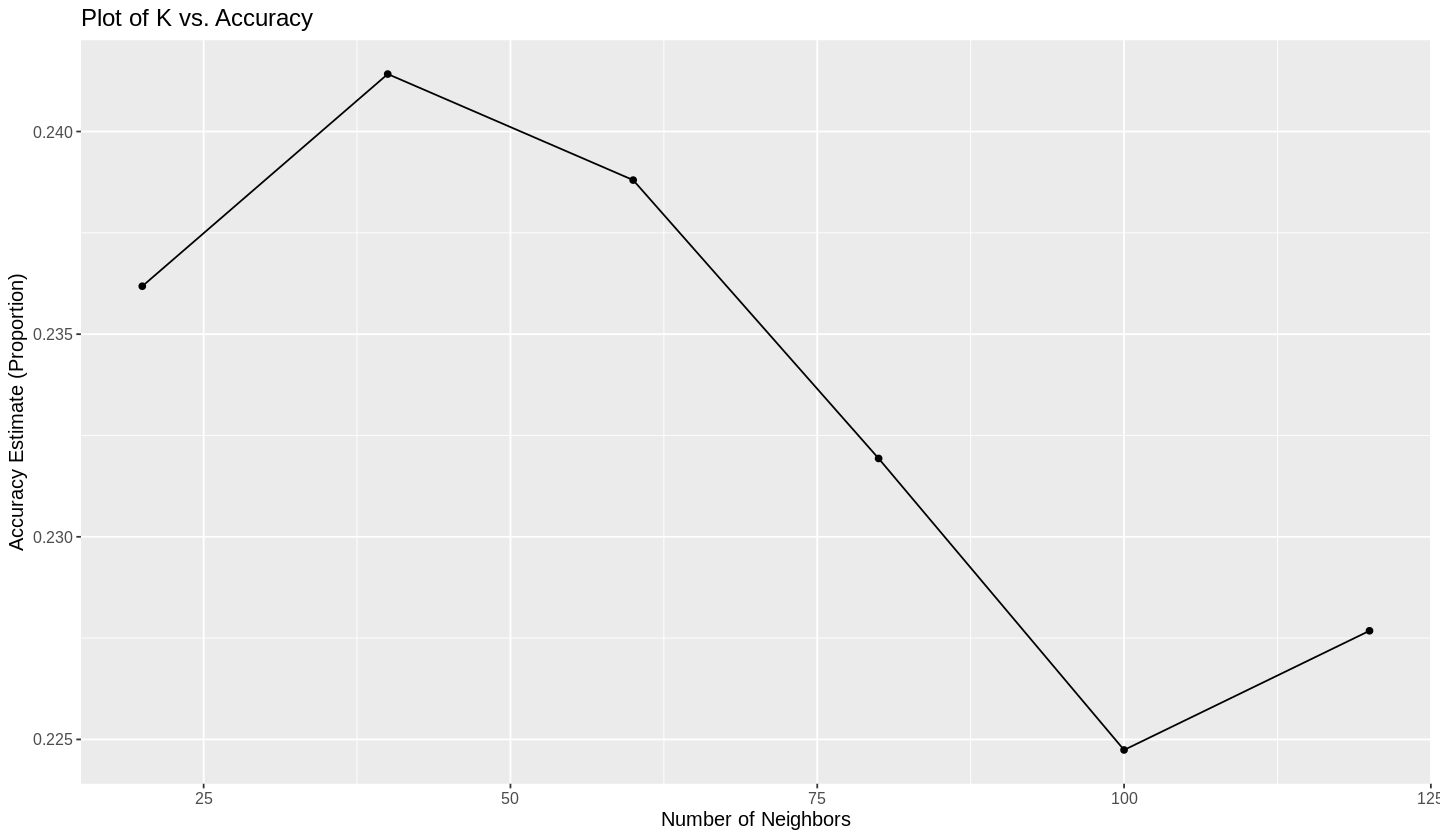

In [11]:
# Perform 5-fold cross-validation
spotify_mbti_vfold <- vfold_cv(spotify_mbti_train, v = 5, strata = mbti)

# Create recipe and standardize variables
spotify_mbti_recipe <- recipe(mbti ~ danceability_mean + energy_mean + loudness_mean + mode_mean + speechiness_mean + acousticness_mean + liveness_mean + valence_mean + tempo_mean + instrumentalness_mean + major_count + minor_count, data = spotify_mbti_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Create model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create tibble of k values
k_vals <- tibble(neighbors = seq(from = 20, to = 120, by = 20))

# Add recipe and model specification for training
knn_results <- workflow() |>
    add_recipe(spotify_mbti_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = spotify_mbti_vfold, grid = k_vals) |>
    collect_metrics()

# Create data frame of accuracies for k values
accuracies <- filter(knn_results, .metric == "accuracy")

# Show plot of accuracy vs k
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate (Proportion)") +
    ggtitle("Plot of K vs. Accuracy") +
    theme(text = element_text(size = 12))

accuracy_vs_k

# Retrain classifier with best value for k
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 40) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(spotify_mbti_recipe) |>
    add_model(knn_spec) |>
    fit(data = spotify_mbti_train)

# Show the predictions with the original data
spotify_mbti_predictions <- predict(knn_fit, spotify_mbti_test) |>
    bind_cols(spotify_mbti_test)

spotify_mbti_predictions

## Data Analysis Visualization

To start this section, we will visualize the accuracy of our model by creating a confusion matrix. 

In [12]:
# Show the confusion matrix

confusion <- conf_mat(spotify_mbti_predictions, truth = mbti, estimate = .pred_class)

confusion

          Truth
Prediction INFP ENFP INFJ ENFJ INTP ENTP INTJ ENTJ ISFP ESFP ISTP ESTP ISFJ
      INFP    9    5    6    6    9    2    6    2    6    1    4    0    7
      ENFP    5   26    2   12    7    4    1    1    3   14    6    7    6
      INFJ   11    5   17    4    4    0   11    1    7    6    1    4    9
      ENFJ    5    5    0    9    1    1    2    0   11    2    4    3    6
      INTP    6    3    5    2   21    7   13    1    6    0    9    2    4
      ENTP    0    6    0    1    3   26    3    9    3    5   10    2    0
      INTJ    2    1    5    5   17    3   14    3    3    2    6    3    3
      ENTJ    2    2    5    5    5   13   13   31    5   10   13   20    2
      ISFP    1    7    5    7    3    2    1    1   13    3    3    3    3
      ESFP    3    5    2    1    3    2    2    1    2    8    2    7    0
      ISTP    3    3    2    5    4    7    5    9    6    3    8    7    1
      ESTP    1    2    2    4    3    9    4    7    0    0    6   20  

Currently, we can tell that due to the large number of classes that exist in the dataset, a confusion matrix is not an ideal way to visualize this data. 

Below, we will utilize the "ggplot2::autoplot()" function to create a 

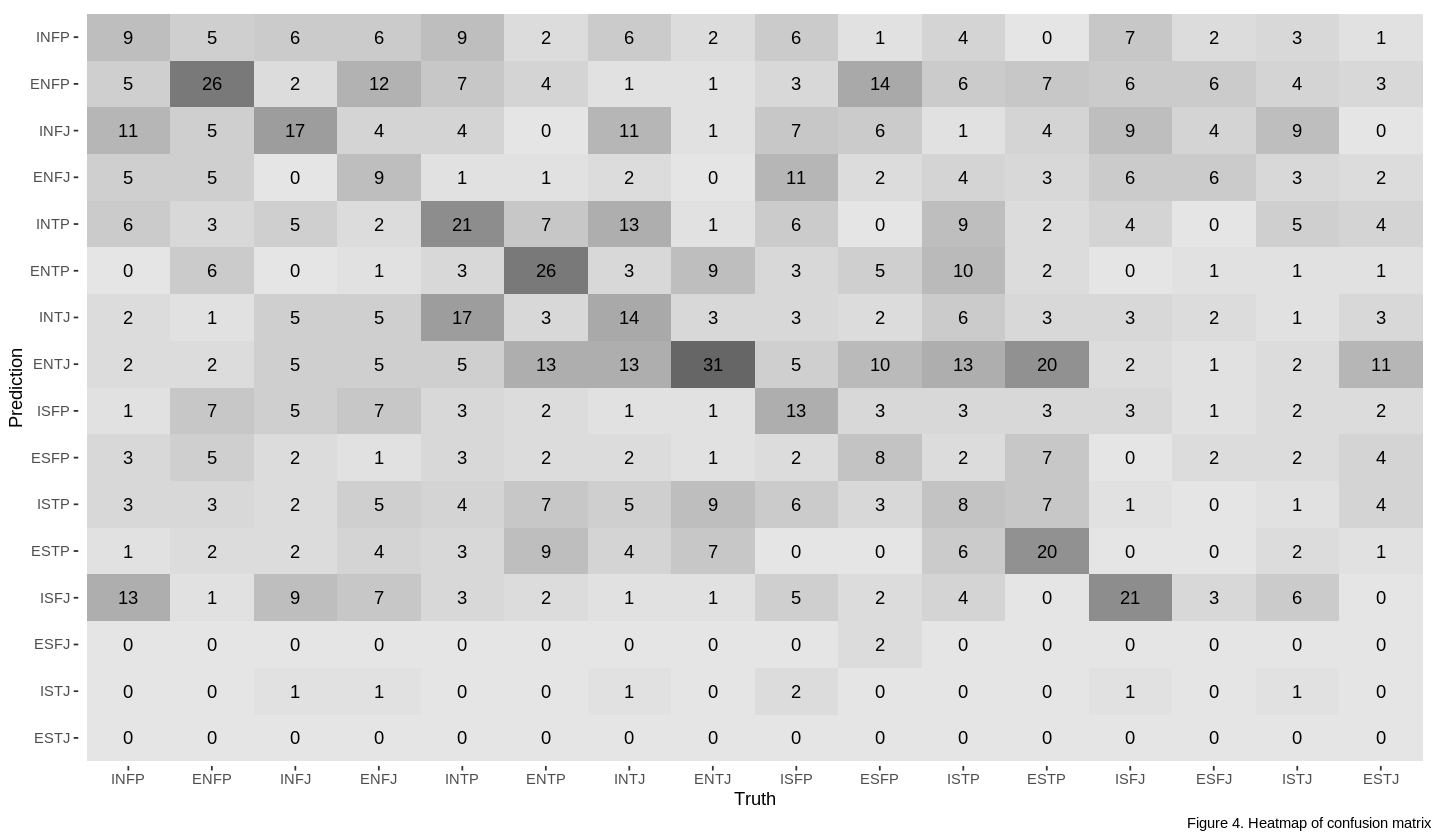

In [15]:
# Create the heatmap

conf_hm = confusion |>
        ggplot2::autoplot(type = "heatmap") +
        labs(caption = "Figure 4. Heatmap of confusion matrix")

conf_hm

We can now visualize our confusion matrix much easier, as it fits all into one plot and the color gradient allows us to better see trends.

Another way we decided that would be helpful in our visualization of the data analysis is by creating a bar chart that allows us to see what proportion of our predictions were correct.

To do this, we can create a bar chart that shows the total number of correct predictions vs incorrect predictions for each MBTI type. We accomplish this by selecting columns mbti and .pred_class from spotify_mbti_predictions, creating a new dataframe that counts the total number of correct/incorrect predictions by matching mbti and .pred_class, and then creating the bar graph using this new dataframe.

`summarise()` has grouped output by 'mbti'. You can override using the
`.groups` argument.


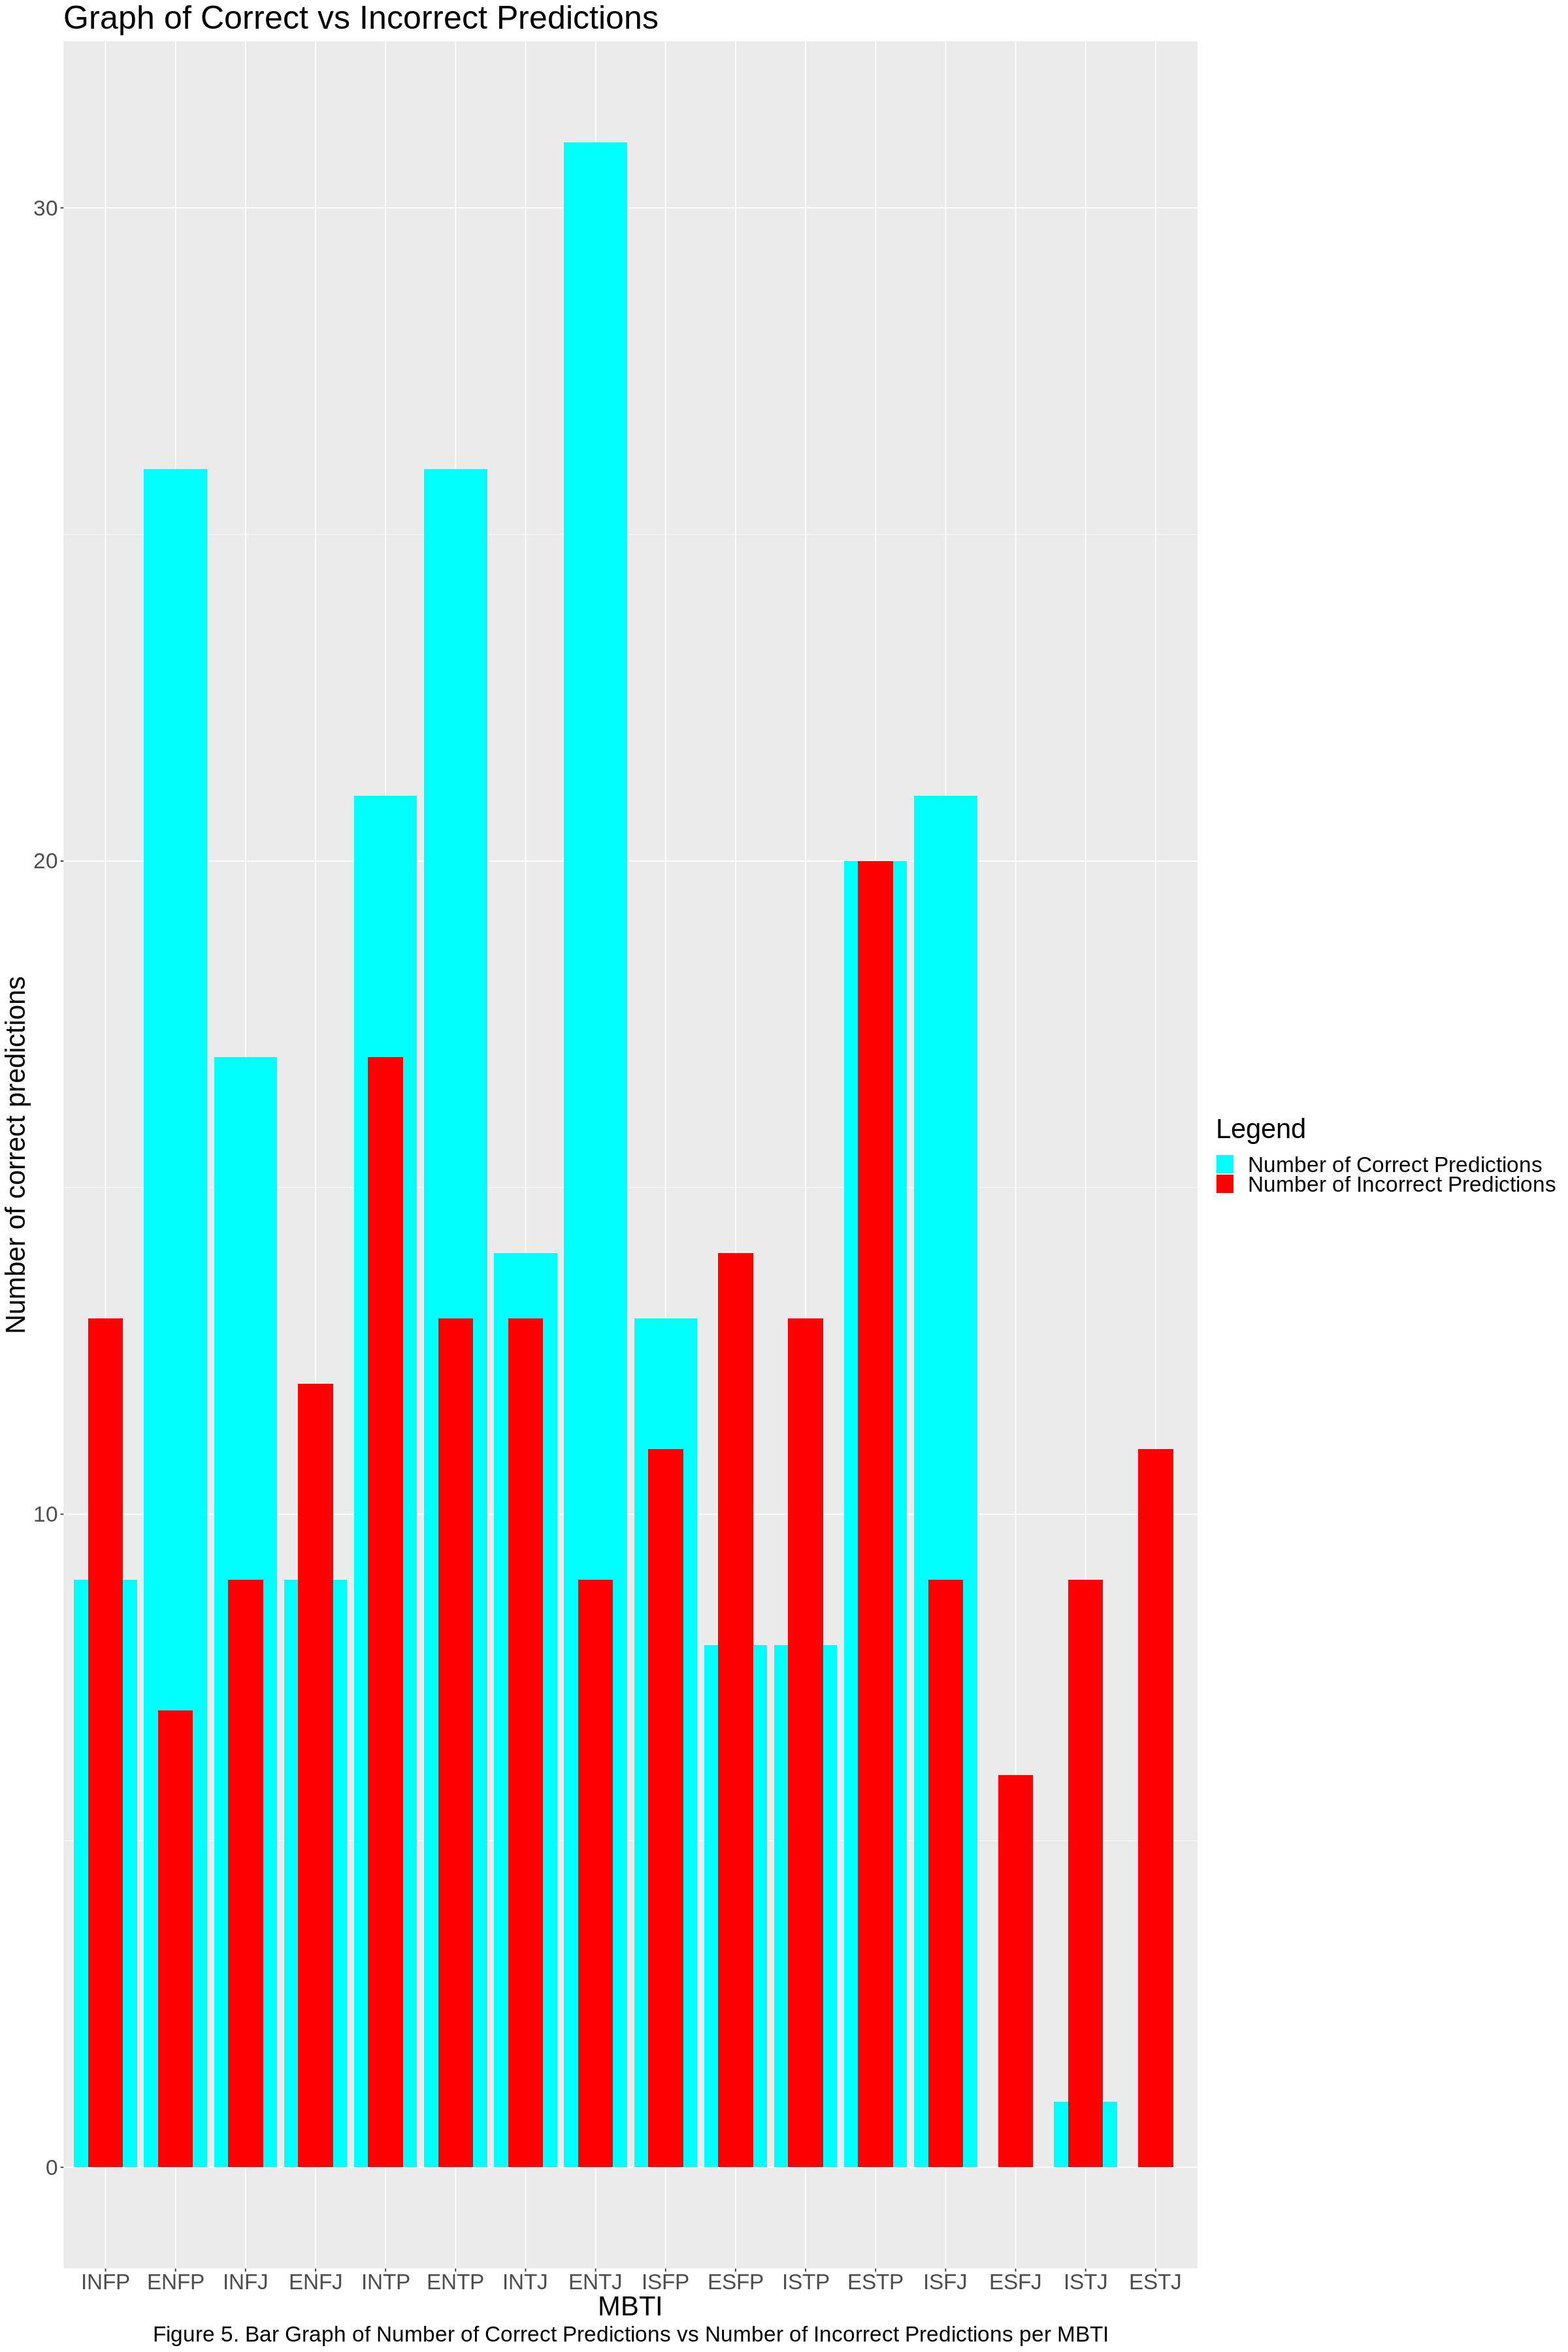

In [121]:

# Select truth and prediction columns and store in new data set

conf_df = spotify_mbti_predictions |>
        select(mbti, .pred_class) |>
        group_by(mbti)

# Create new dataframe that counts number of correct and incorrect predictions

df_count = conf_df |>
        mutate(is_correct = mbti == .pred_class) |>
        group_by(mbti, .pred_class) |>
        summarise(n_correct = sum(is_correct), n_incorrect = sum(!is_correct)) |>
        ungroup() |>
        select(-.pred_class)

# Create a new bar graph with two bars per MBTI

count_plot = df_count |>
        ggplot() +
        geom_bar(aes(x = mbti, y = n_correct, fill = "Number of Correct Predictions"), 
                 stat = "identity", 
                 position = "identity") +
        geom_bar(aes(x = mbti, y = n_incorrect, fill = "Number of Incorrect Predictions"), 
                 stat = "identity", 
                 width = 0.5, 
                 position = position_dodge(width = 1)) +
        labs(x = "MBTI", 
             y = "Number of correct predictions",
             caption = "Figure 5. Bar Graph of Number of Correct Predictions vs Number of Incorrect Predictions per MBTI",
             fill = "Legend",
             title = "Graph of Correct vs Incorrect Predictions") +
        theme(text = element_text(size = 25),
             plot.caption = element_text(hjust=0.5)) +
        scale_fill_manual(values = c("Number of Correct Predictions" = "cyan", "Number of Incorrect Predictions" = "red"))

count_plot


## Discussion
* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

## References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.

* https://www.kaggle.com/datasets/xtrnglc/spotify-mbti-playlists
* https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/
* https://www.verywellmind.com/music-and-personality-2795424